
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt
import pandas as pd
import shap
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean

from sklearn.preprocessing import LabelEncoder

In [3]:
# loading csv
df_original = pd.read_csv('data/final_dataset.csv').drop("Unnamed: 0", axis=1)

df = df_original.copy()

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [54]:
df_original[df_original["Name"] == "Mohamed-Salah"].groupby(["Pos"]).mean()["Total Points"]

Pos
FW       8.000000
FW,RW    2.000000
RM,FW    3.000000
RW       7.070175
RW,FW    5.000000
RW,RM    4.000000
Name: Total Points, dtype: float64

In [56]:
df_original["Cmp"].unique()

array([ 69.,  64.,  45.,  58.,  50.,  36.,  73.,  78.,  44.,  34.,  66.,
        16.,  70.,  38.,  67.,  53.,  48.,  42.,  79.,  14.,  21.,  51.,
        54.,  55.,  32.,  41.,  30.,  60.,  65.,  68.,  96.,   7.,   0.,
        18.,  29.,  17.,  33.,  28.,  43.,  46.,  39.,  13.,  27.,  20.,
        23.,  24.,  22.,  11.,   9.,  10.,  72.,  49.,  31.,  15.,  25.,
        35.,  37.,  12.,  19.,  57.,  52.,  26.,  80.,   1.,  56.,  40.,
         3.,   2.,   8.,   5.,   4.,   6.,  61.,  47.,  74.,  81.,  59.,
       105.,  88.,  94.,  63.,  87.,  75.,  84.,  89.,  85.,  71.,  77.,
        62.,  82., 106.,  90.,  nan,  76.,  86.,  95., 103., 104., 111.,
       107.,  93., 109., 117., 110., 118.,  92.,  83.,  97., 108., 102.,
       100., 101.,  91.,  99., 113.,  98., 116., 171., 112., 128., 127.,
       115., 142., 129., 119., 124., 125., 137., 143., 132., 114.])

In [5]:
df.columns

Index(['Date', 'Day', 'Comp', 'Round', 'Venue', 'Squad', 'Opponent', 'Start',
       'Pos', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR',
       'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA', 'GCA',
       'Cmp', 'Att', 'Cmp%', 'PrgP', 'Carries', 'PrgC', 'Att.1', 'Succ',
       'Match Report', 'Name', 'Season', 'Fls', 'Fld', 'Off', 'Crs', 'TklW',
       'OG', 'PKwon', 'PKcon', 'WDL', 'GoalsTeams', 'Team Score', 'Opp Score',
       'CS', 'Was Home', 'GW', 'neutral_name', 'Total Points', 'FPL position',
       'Opp rating', 'Team rating', 'ScoreForLast5', 'ScoreAgainstLast5',
       'Min_points', 'MinAvgOverall', 'GlsAvgOverall', 'AstAvgOverall',
       'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall', 'xAGAvgOverall',
       'CSAvgOverall', 'Team ScoreAvgOverall', 'Opp ScoreAvgOverall'],
      dtype='object')

# Preparing dataset

In [6]:
# features = ["Was Home", "Team rating", "Opp rating", 'ScoreForLast5', 'ScoreAgainstLast5', 
#         'MinAvgOverall', 'GlsAvgOverall',
#        'AstAvgOverall', 'CrdYAvgOverall', 'CrdRAvgOverall', 'xGAvgOverall',
#        'xAGAvgOverall', 'CSAvgOverall', 'Team ScoreAvgOverall',
#        'Opp ScoreAvgOverall']

In [7]:
def calculate_xg_points(row):
    if row["FPL position"] == "GK":
        return row["xG"] * 6
    elif row["FPL position"] == "DEF":
        return row["xG"] * 6
    elif row["FPL position"] == "MID":
        return row["xG"] * 5
    elif row["FPL position"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [8]:
def calculate_cs_points(row):
    if row["FPL position"] == "GK":
        return row["xG"] * 4
    elif row["FPL position"] == "DEF":
        return row["xG"] * 4
    elif row["FPL position"] == "MID":
        return row["xG"] * 1
    elif row["FPL position"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [9]:
to_predict = ["Total Points"]
features1 = ["Was Home", "Team rating", "Opp rating", 
             # 'ScoreForLast5', 'ScoreAgainstLast5',
             "Start"]
features_to_roll = [
                "Min", 
                'Gls', 'Ast', 'Sh',
                'SoT', 'CrdY', 'CrdR', 'xAG', 
                # 'CS', "xG",
                'Team Score', 'Opp Score',
                "xGPoints", "CSPoints",
            ]
info = ["Name", "GW", "Season", "Squad", "Opponent", "Was Home", "Team rating", "Opp rating", "FPL position"]

In [10]:
def add_rolling_features(df, features1, features_to_roll):
    rolling_gameweeks = [5]
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().reset_index()
        form_means = form_means.shift(1)
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [11]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)
        df = df.drop(c, axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [12]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 2,
        'Y*': 1,
        'N': 0,
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [13]:
df, features = add_rolling_features(df, features1, features_to_roll)

In [14]:
# df, features = ohe(df, ["FPL position"], features)

In [15]:
df = label_encoding(df, "Start")

In [16]:
df = df[np.unique(features + info + to_predict)]

In [17]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [18]:
# dropping NaNs
df = df.dropna(axis=0)

In [19]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [20]:
df.columns

Index(['Ast_5', 'CSPoints_5', 'CrdR_5', 'CrdY_5', 'FPL position', 'GW',
       'Gls_5', 'Min_5', 'Name', 'Opp Score_5', 'Opp rating', 'Opponent',
       'Season', 'Sh_5', 'SoT_5', 'Squad', 'Start', 'Team Score_5',
       'Team rating', 'Total Points', 'Was Home', 'level_1_5', 'xAG_5',
       'xGPoints_5'],
      dtype='object')

# Choosing features and splitting data

In [21]:
GAMEWEEK_TO_PREDICT = 30
SEASON_TO_PREDICT = "2022-23"

In [22]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] <= SEASON_TO_PREDICT) & (df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] <= SEASON_TO_PREDICT) & (df["GW"] >= 1) & (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [23]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [24]:
X_train.shape, X_test.shape

((16887, 17), (373, 17))

# Model

In [25]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [26]:
lgbm = LGBMRegressor()
xgb = XGBRegressor()
gbr = GradientBoostingRegressor()

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [27]:
# model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [28]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 6.03 s
Wall time: 878 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

# Evaluation

In [29]:
# make predictions on the test data
predictions = model.predict(X_test)

In [30]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [31]:
df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
df_predictions.loc[:, "pred"] = predictions

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate the MAE and MSE scores
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
pairwise_acc = pairwise_accuracy(np.array(y_test), predictions)

In [33]:
print("MAE:", mae)
print("MSE:", mse)
print("Pairwise accuracy:", pairwise_acc)

MAE: 1.5582953796846213
MSE: 5.3216037863077075
Pairwise accuracy: 0.6243766035342616


In [34]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [35]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

In [36]:
preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)

In [37]:
preds.head(30)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,FPL position,Total Points,pred
125,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FWD,9.0,8.645445
119,Gabriel-Dos-Santos,30,2022-23,Arsenal,Liverpool,0.0,1956.794434,1929.042725,DEF,1.0,7.681466
11,Alexander-Isak,30,2022-23,Newcastle Utd,Brentford,0.0,1871.874634,1792.455444,FWD,5.0,6.957180
45,Bukayo-Saka,30,2022-23,Arsenal,Liverpool,0.0,1956.794434,1929.042725,MID,1.0,6.558325
104,Emiliano-Martinez,30,2022-23,Aston Villa,Nott'ham Forest,1.0,1799.512573,1643.347290,GK,9.0,6.334603
177,Joe-Willock,30,2022-23,Newcastle Utd,Brentford,0.0,1871.874634,1792.455444,MID,2.0,6.221193
356,Tyrone-Mings,30,2022-23,Aston Villa,Nott'ham Forest,1.0,1799.512573,1643.347290,DEF,6.0,6.167816
2,Aaron-Ramsdale,30,2022-23,Arsenal,Liverpool,0.0,1956.794434,1929.042725,GK,1.0,6.120173
207,Kevin-De-Bruyne,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,9.0,6.059165
137,Ilkay-Gundogan,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,5.813354


In [38]:
preds[preds["Squad"] == "Manchester City"].head(20)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,FPL position,Total Points,pred
207,Kevin-De-Bruyne,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,9.0,6.059165
137,Ilkay-Gundogan,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,5.813354
308,Riyad-Mahrez,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,1.0,5.531864
143,Jack-Grealish,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,12.0,3.918094
108,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,3.805899
196,Julian-Alvarez,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,5.0,3.111283
318,Ruben-Dias,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.033254
234,Manuel-Akanji,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,2.897831
97,Ederson,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,GK,2.0,2.792445
270,Nathan-Ake,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,2.652627


In [39]:
preds[preds["FPL position"] == "FWD"].head(10)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,FPL position,Total Points,pred
125,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FWD,9.0,8.645445
11,Alexander-Isak,30,2022-23,Newcastle Utd,Brentford,0.0,1871.874634,1792.455444,FWD,5.0,6.957180
160,Jamie-Vardy,30,2022-23,Leicester City,Bournemouth,1.0,1736.191162,1656.900146,FWD,1.0,5.026529
283,Ollie-Watkins,30,2022-23,Aston Villa,Nott'ham Forest,1.0,1799.512573,1643.347290,FWD,7.0,4.874066
142,Ivan-Toney,30,2022-23,Brentford,Newcastle Utd,1.0,1792.455444,1871.874634,FWD,4.0,4.824494
290,Patrick-Bamford,30,2022-23,Leeds United,Crystal Palace,1.0,1715.622681,1739.438232,FWD,6.0,4.253763
199,Kai-Havertz,30,2022-23,Chelsea,Wolves,0.0,1846.563354,1710.233032,FWD,2.0,4.191776
280,Odsonne-Edouard,30,2022-23,Crystal Palace,Leeds United,0.0,1739.438232,1715.622681,FWD,6.0,4.176512
74,Danny-Ings,30,2022-23,West Ham,Fulham,0.0,1745.203857,1722.582764,FWD,2.0,3.988616
50,Carlos-Vinicius,30,2022-23,Fulham,West Ham,1.0,1722.582764,1745.203857,FWD,1.0,3.933223


# Feature importance and influence

In [40]:
# plot_importance(model)

In [41]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [42]:
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

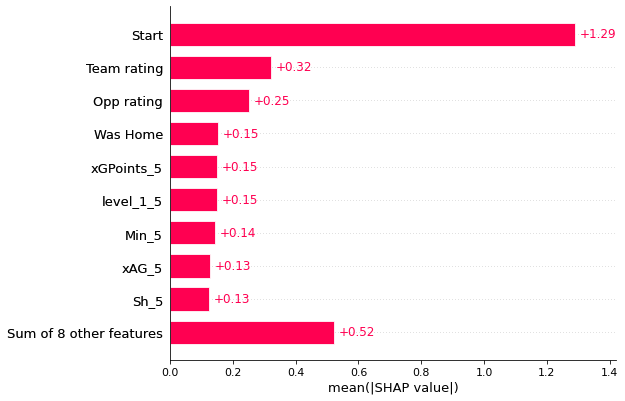

In [43]:
shap.plots.bar(shap_values)

In [44]:
# shap.plots.beeswarm(shap_values)

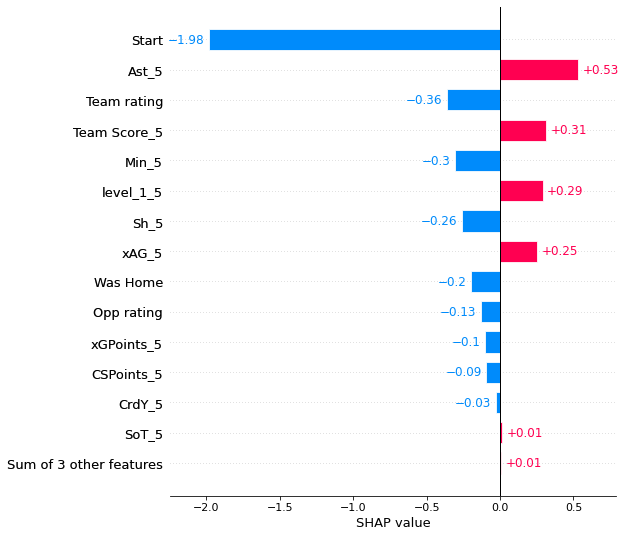

In [45]:
shap.plots.bar(shap_values[218], max_display=15)